# Discrepancy study: usecase on Adult dataset

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals, pool2graph_cat_FJ2_2

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

# Preparation

### Load the data, train a pool of classifiers

* The dataset is Adult, containing both continuous and categorical variables
* We build a pool of classifiers and evaluate their performance

In [5]:
# Get data and fit a pool of classifiers on it
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cat')
print(X_train.shape, y_train.mean())

pool1 = pool.BasicPool() # TODO: other pool, better one
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score
print({c: f1_score(y_test, preds[c]) for c in preds.columns})


taking only 3000 instances
(2010, 96) 0.24925373134328357
[17:50:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'SVMrbf': 0.5958549222797928, 'RF100': 0.37362637362637363, 'RF200': 0.2549800796812749, 'XGB': 0.6464646464646464}


It looks that several of these classifiers have similar performance. How can we choose among them? 

In [7]:
pool1.predict_discrepancies(X_test).mean()

0.17484848484848484

We measure that classifiers disagree over 17,5% of test instances. What can we learn about these discrepancies ? 

### Build the graph with DIG

* DIG relies on two main parameters: k_init and max_epochs. Essentially, the higher these two are, the better.
* Here we select random values that seem good enough

In [6]:
# build p2g
p2g = pool2graph_cat_FJ2_2.pool2graph(X_train, y_train, pool1, k_init=3, categorical_names=cat_names)

p2g.fit(max_epochs=10)
print(len(p2g.G.nodes))

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5
INFO:root:### EPOCH #6
INFO:root:### EPOCH #7
INFO:root:### EPOCH #8
INFO:root:### EPOCH #9


KeyboardInterrupt: 

# Understanding discrepancies

In [5]:
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
len(intervals)

7823

Text(0.5, 1.0, 'Average change among continuous features')

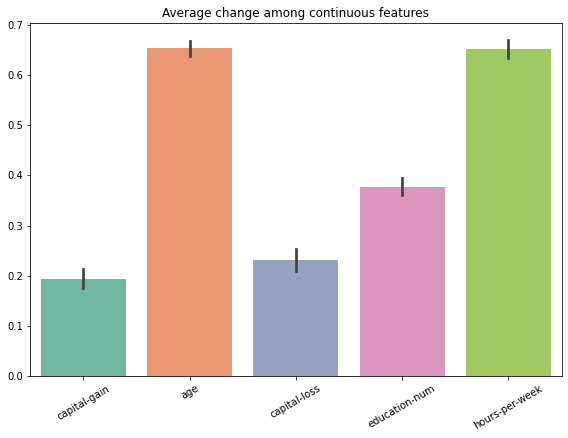

In [22]:
global_interval_coord = []
for di in intervals:
    interval_coord = np.array((di.border_features.iloc[0] - di.border_features.iloc[1]).abs())
    global_interval_coord.append(interval_coord)
global_interval_coord = np.array(global_interval_coord)
global_interval_coord = pd.DataFrame(global_interval_coord, columns = X_train.columns)

from matplotlib.pyplot import figure
figure(figsize=(8, 6))
sns.set_style()
ax = sns.barplot(data=global_interval_coord.iloc[:, :5], ci=95, palette="mako")
ax.set_xticklabels(X_train.columns[:5],rotation=30)
plt.tight_layout()
plt.title("Average change among continuous features")



Age is much more subject to disagreement among classifiers than e.g. captial-gain

Text(0.5, 1.0, 'Average number of intervals implying a change among each feature')

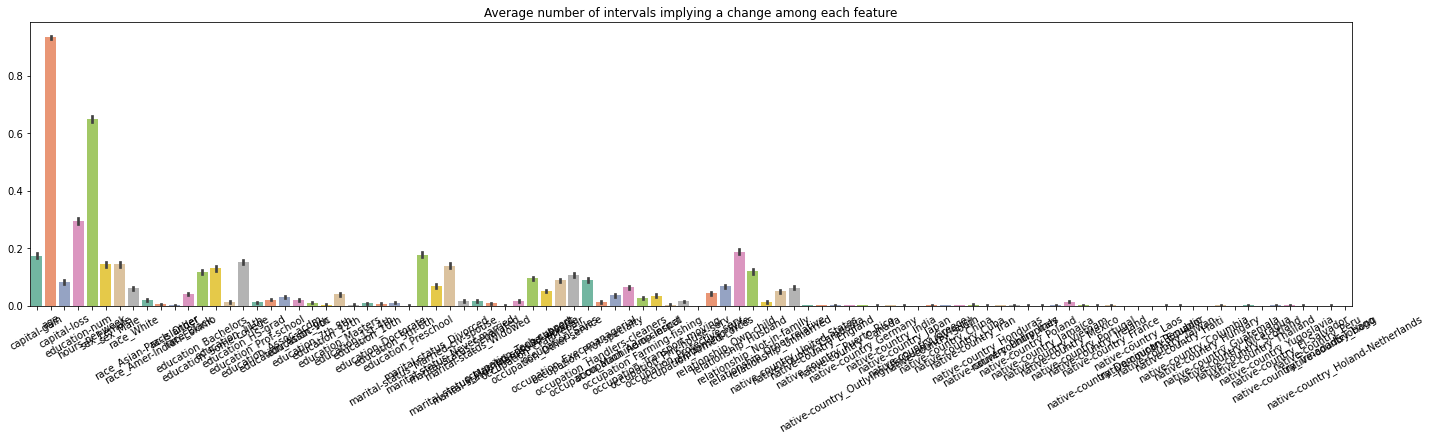

In [25]:
global_interval_coord = []
for di in intervals:
    interval_coord = np.array((di.border_features.iloc[0] - di.border_features.iloc[1]).abs())
    global_interval_coord.append(interval_coord > 0.0)
global_interval_coord = np.array(global_interval_coord)
global_interval_coord = pd.DataFrame(global_interval_coord, columns = X_train.columns)


from matplotlib.pyplot import figure
figure(figsize=(20, 6))
sns.set_style()
ax = sns.barplot(data=global_interval_coord, ci=95, palette="Set2")
ax.set_xticklabels(X_train.columns,rotation=30)
plt.tight_layout()
plt.title('Average number of intervals implying a change among each feature')


on a l'impression que les catégorielles interviennent moins mais en fait c'est logique;... on peut pas vraiment les comparer tel quel. (un changement peut être minime mais présent chez les continues). Un biais potentiel aussi: le fait que les modalités ne soient pas également représentées.

### Position (dans le feature space) des zones de discrepancy

Où sont les zones de discrepancy ? Clustering des noeuds pour le comprendre

        capital-gain             age       capital-loss       education-num  \
                mean count      mean count         mean count          mean   
cluster                                                                       
0           0.066348   403  0.409182   403     0.181593   403      1.159645   
1          -0.089650   178  0.389783   178     0.159579   178      0.330812   
2          -0.000237     5  0.175732     5    -0.219875     5      0.033023   
3          -0.054574   122  0.118432   122     0.026216   122      0.138612   
4          -0.147271     5  0.278899     5    -0.219875     5     -0.250313   
5           0.436270     5  0.675426     5    -0.219875     5      0.443824   
6          -0.147271     4  0.104404     4     1.023739     4      0.846459   
7           0.966824     7  0.499846     7    -0.219875     7      0.728232   
8          -0.070379   633  0.432119   633     0.184750   633     -0.165549   
9          -0.147271     4  0.449758     4     0.860

<Figure size 1440x432 with 0 Axes>

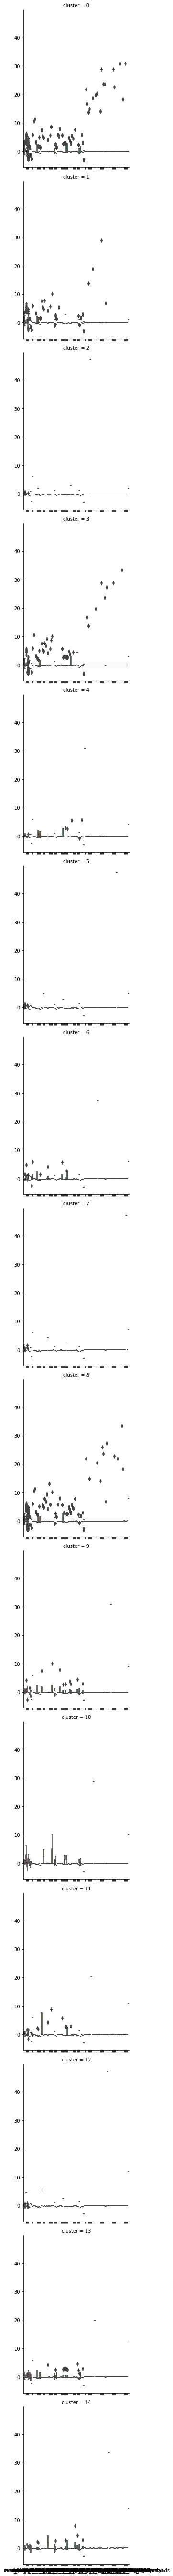

In [33]:
from sklearn.cluster import KMeans

oneborder = np.array([di.border_features.iloc[0] for di in intervals])
coord_intervals = []
for di in intervals:
    a, b = di.border_features.iloc[0], di.border_features.iloc[1]
    if a[0] > 0:
        interval_coord = a - b
    else:
        interval_coord = a - b
    coord_intervals.append(interval_coord)
coord_intervals = np.array(coord_intervals)
coord_intervals = pd.DataFrame(coord_intervals, columns=X_train.columns)

nodes = p2g.get_nodes_attributes(p2g.get_nodes(discrepancies=True))[0]

clusters_nodes = KMeans(n_clusters=15, n_jobs=-1).fit_predict(nodes)


clusters = clusters_nodes.copy()
data = nodes.copy()
data["cluster"] = clusters
print(data.groupby("cluster").agg(['mean', 'count']))
figure(figsize=(20, 6))
sns.catplot(data=data, col="cluster", kind="box", col_wrap=1)

### Comparaison avec et sans catégorielles: temps, nombre de noeuds

In [10]:
%%time
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult')
pool1 = pool.BasicPool()
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score
print({c: f1_score(y_test, preds[c]) for c in preds.columns})


p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=10)
p2g.fit(max_epochs=4)
print(len(p2g.G.nodes))

taking only 5000 instances
{'SVMrbf': 0.5477707006369428, 'SVMpoly': 0.46511627906976744, 'SVMsigmoid': 0.5219638242894057, 'RF50': 0.5975443383356072, 'RF100': 0.5978260869565217, 'RF200': 0.5953360768175583, 'KNN5': 0.5746478873239436}


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4


4600
CPU times: user 8.06 s, sys: 82.9 ms, total: 8.14 s
Wall time: 8.14 s


In [4]:
%%time
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cath')
pool1 = pool.BasicPool()
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score
print({c: f1_score(y_test, preds[c]) for c in preds.columns})


p2g = pool2graph_cat.pool2graph(X_train, y_train, pool1, k_init=10, categorical_names=cat_names)
p2g.fit(max_epochs=4)
print(len(p2g.G.nodes))

taking only 1000 instances
{'SVMrbf': 0.5401929260450161, 'SVMpoly': 0.47368421052631576, 'SVMsigmoid': 0.42732919254658386, 'RF50': 0.5418439716312057, 'RF100': 0.5479833101529902, 'RF200': 0.5464788732394366, 'KNN5': 0.5227272727272727}


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4


11020
CPU times: user 20.1 s, sys: 259 ms, total: 20.4 s
Wall time: 20.3 s
